In [1]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


In [2]:
batch_size = 32
img_height = 180
img_width = 180

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory("/content/gdrive/MyDrive/xray",
                                                      validation_split=0.2,
                                                      subset="training",   
                                                      seed=123,
                                                      image_size=(img_height, img_width),
                                                      batch_size=batch_size
                                                        )

val_ds = tf.keras.utils.image_dataset_from_directory("/content/gdrive/MyDrive/xray",
                                                      validation_split=0.2,
                                                      subset="validation",     
                                                      seed=123,
                                                      image_size=(img_height, img_width),
                                                      batch_size=batch_size
                                                        )


Found 10702 files belonging to 2 classes.
Using 8562 files for training.
Found 10702 files belonging to 2 classes.
Using 2140 files for validation.


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

test_ds = val_ds.take(10) 
val_ds = val_ds.skip(10)

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [6]:
# Gender Classification on TPU

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = [180, 180]
#CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

In [8]:
## Build the CNN

In [9]:
from tensorflow import keras
from tensorflow.keras import layers


def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)

    return outputs


def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs

In [10]:
def build_model():
    inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)

    x = conv_block(32, x)
    x = conv_block(64, x)

    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)

    x = conv_block(256, x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = dense_block(512, 0.7, x)
    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
## Train the model

In [12]:
### Defining callbacks

In [13]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [14]:
initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

In [15]:
### Fit the model

In [16]:
with strategy.scope():
    model = build_model()

    METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    #class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/10
268/268 [==============================] - 1166s 4s/step - loss: 0.5904 - binary_accuracy: 0.6943 - precision: 0.6638 - recall: 0.5529 - val_loss: 6.0784 - val_binary_accuracy: 0.4132 - val_precision: 0.4119 - val_recall: 1.0000
Epoch 2/10
268/268 [==============================] - 814s 3s/step - loss: 0.4173 - binary_accuracy: 0.8146 - precision: 0.7896 - recall: 0.7622 - val_loss: 1.0531 - val_binary_accuracy: 0.6929 - val_precision: 0.5804 - val_recall: 0.9118
Epoch 3/10
268/268 [==============================] - 775s 3s/step - loss: 0.3400 - binary_accuracy: 0.8537 - precision: 0.8288 - recall: 0.8216 - val_loss: 0.3226 - val_binary_accuracy: 0.8632 - val_precision: 0.7794 - val_recall: 0.9305
Epoch 4/10
268/268 [==============================] - 766s 3s/step - loss: 0.3001 - binary_accuracy: 0.8740 - precision: 0.8516 - recall: 0.8480 - val_loss: 0.3304 - val_binary_accuracy: 0.8665 - val_precision: 0.7834 - val_recall: 0.9332
Epoch 5/10
268/268 [=======================

In [17]:
## Visualizing model performance

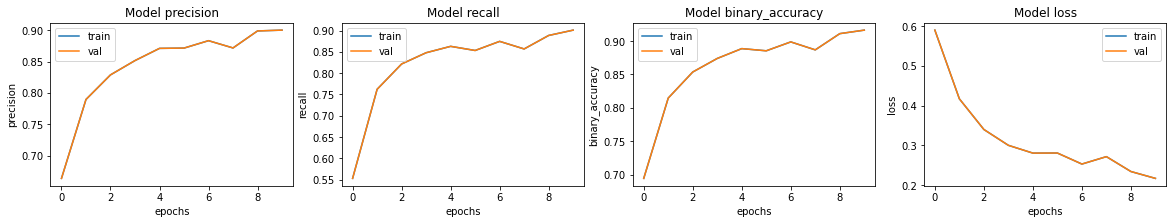

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history[met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [19]:
### Predict and evaluate results

In [20]:
model.evaluate(test_ds, return_dict=True)

10/10 [==============================] - 24s 2s/step - loss: 0.1667 - binary_accuracy: 0.9312 - precision: 0.9632 - recall: 0.8851


{'loss': 0.16671302914619446,
 'binary_accuracy': 0.9312499761581421,
 'precision': 0.9632353186607361,
 'recall': 0.8851351141929626}

In [21]:
for image, label in test_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (32, 180, 180, 3)
Label:  [1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1]


In [22]:
# imageId - same as the PNG filename
# gender - 0 for female and 1 for male
CLASS_NAMES = ["FEMALE", "MALE"]

1/1 [==============================] - 2s 2s/step
This image is 1.18 percent FEMALE
This image is 98.82 percent MALE


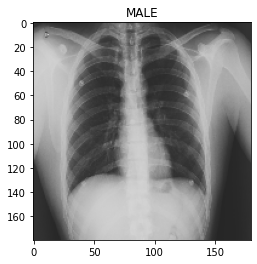

1/1 [==============================] - 1s 565ms/step
This image is 0.47 percent FEMALE
This image is 99.53 percent MALE


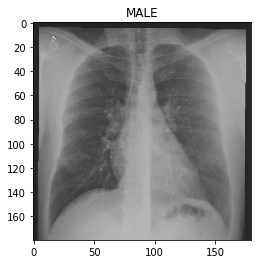

1/1 [==============================] - 1s 592ms/step
This image is 99.67 percent FEMALE
This image is 0.33 percent MALE


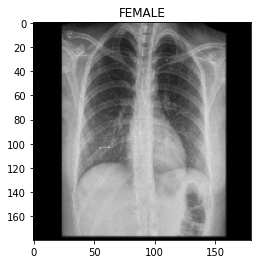

1/1 [==============================] - 1s 573ms/step
This image is 0.57 percent FEMALE
This image is 99.43 percent MALE


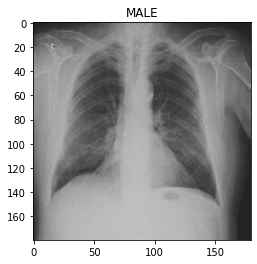

1/1 [==============================] - 1s 560ms/step
This image is 99.82 percent FEMALE
This image is 0.18 percent MALE


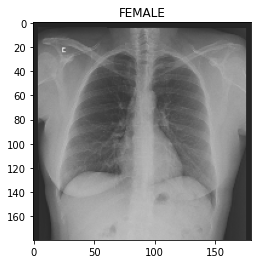

1/1 [==============================] - 1s 559ms/step
This image is 3.18 percent FEMALE
This image is 96.82 percent MALE


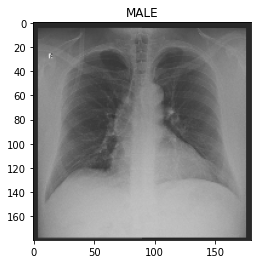

1/1 [==============================] - 1s 657ms/step
This image is 98.93 percent FEMALE
This image is 1.07 percent MALE


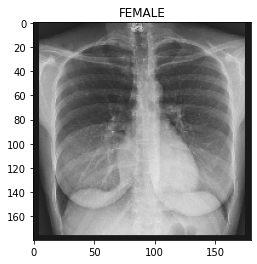

1/1 [==============================] - 1s 690ms/step
This image is 99.58 percent FEMALE
This image is 0.42 percent MALE


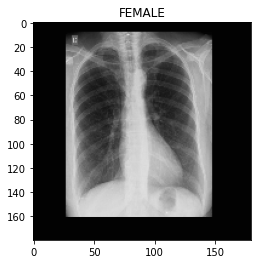

1/1 [==============================] - 1s 739ms/step
This image is 99.62 percent FEMALE
This image is 0.38 percent MALE


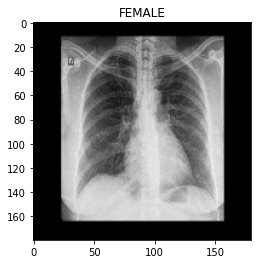

1/1 [==============================] - 1s 662ms/step
This image is 99.84 percent FEMALE
This image is 0.16 percent MALE


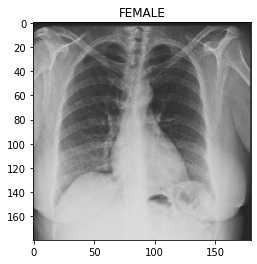

1/1 [==============================] - 1s 652ms/step
This image is 99.99 percent FEMALE
This image is 0.01 percent MALE


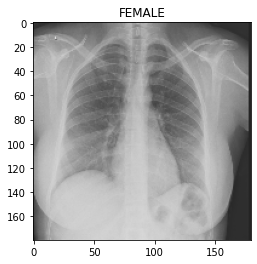

1/1 [==============================] - 1s 918ms/step
This image is 99.55 percent FEMALE
This image is 0.45 percent MALE


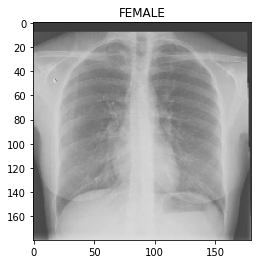

1/1 [==============================] - 1s 1s/step
This image is 70.89 percent FEMALE
This image is 29.11 percent MALE


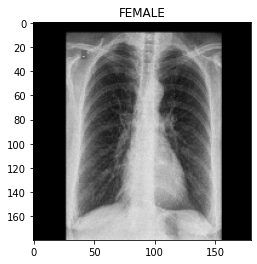

1/1 [==============================] - 1s 1s/step
This image is 0.69 percent FEMALE
This image is 99.31 percent MALE


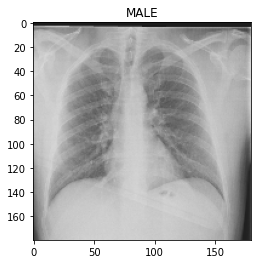

1/1 [==============================] - 1s 1s/step
This image is 99.75 percent FEMALE
This image is 0.25 percent MALE


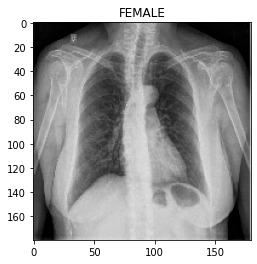

1/1 [==============================] - 1s 675ms/step
This image is 1.07 percent FEMALE
This image is 98.93 percent MALE


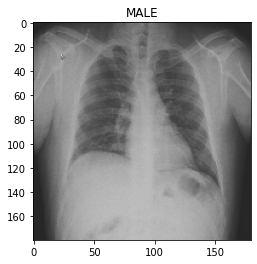

1/1 [==============================] - 1s 709ms/step
This image is 2.24 percent FEMALE
This image is 97.76 percent MALE


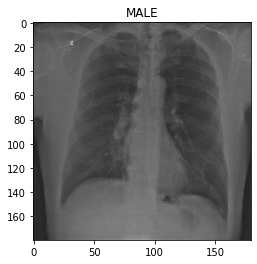

1/1 [==============================] - 1s 656ms/step
This image is 3.70 percent FEMALE
This image is 96.30 percent MALE


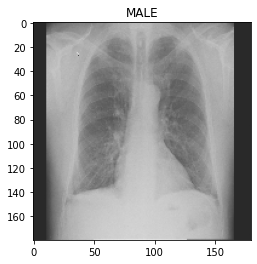

1/1 [==============================] - 1s 555ms/step
This image is 6.61 percent FEMALE
This image is 93.39 percent MALE


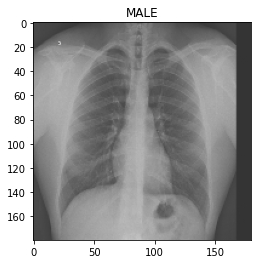

1/1 [==============================] - 1s 563ms/step
This image is 0.87 percent FEMALE
This image is 99.13 percent MALE


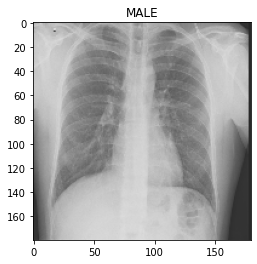

1/1 [==============================] - 1s 582ms/step
This image is 99.43 percent FEMALE
This image is 0.57 percent MALE


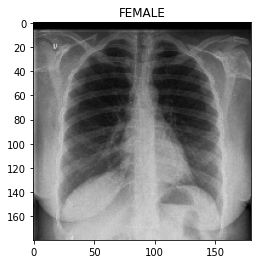

1/1 [==============================] - 1s 589ms/step
This image is 0.37 percent FEMALE
This image is 99.63 percent MALE


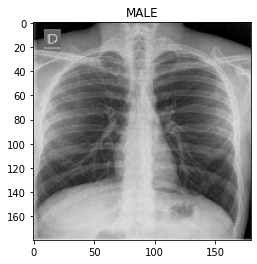

1/1 [==============================] - 1s 567ms/step
This image is 82.22 percent FEMALE
This image is 17.78 percent MALE


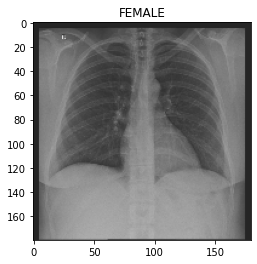

1/1 [==============================] - 1s 562ms/step
This image is 99.34 percent FEMALE
This image is 0.66 percent MALE


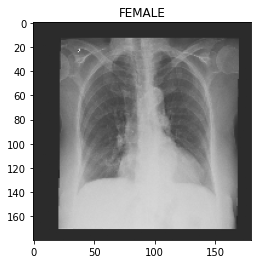

1/1 [==============================] - 1s 579ms/step
This image is 92.53 percent FEMALE
This image is 7.47 percent MALE


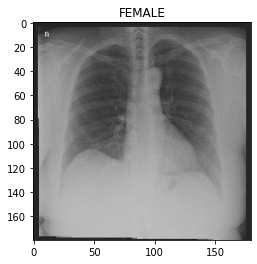

1/1 [==============================] - 1s 573ms/step
This image is 99.98 percent FEMALE
This image is 0.02 percent MALE


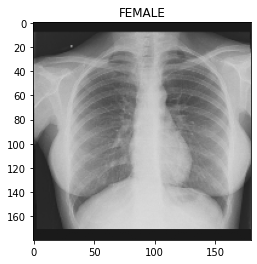

1/1 [==============================] - 1s 573ms/step
This image is 99.93 percent FEMALE
This image is 0.07 percent MALE


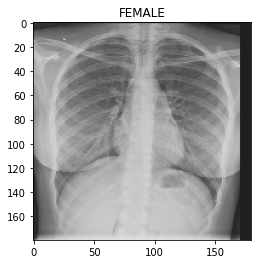

1/1 [==============================] - 1s 891ms/step
This image is 86.17 percent FEMALE
This image is 13.83 percent MALE


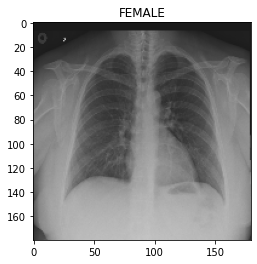

1/1 [==============================] - 1s 1s/step
This image is 2.24 percent FEMALE
This image is 97.76 percent MALE


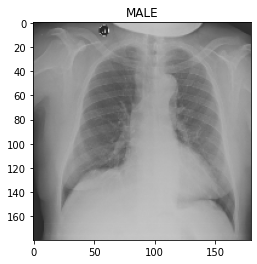

1/1 [==============================] - 1s 1s/step
This image is 99.76 percent FEMALE
This image is 0.24 percent MALE


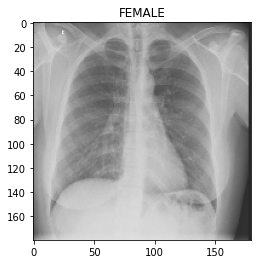

In [23]:
for image, label in test_ds.take(1):
  for j in range(0,30):
    prediction = model.predict(test_ds.take(1))[j]
    scores = [1 - prediction, prediction]
    for score, name in zip(scores, CLASS_NAMES):
        print("This image is %.2f percent %s" % ((100 * score), name))
    plt.imshow(image[j] / 255.0)
    plt.title(CLASS_NAMES[label[j].numpy()])
    plt.show()